# Keypoint(Patch) Description
<a id='top_cell'></a>  
This project will be all about defining and training a convolutional neural network to perform keypoint  description. 
PyTorch tutorials are available at here: [pytorch tutorials](https://github.com/yunjey/pytorch-tutorial)

Today we will go through:
### 1. [Load and visualize the data](#load_data_cell)
### 2. [Build an example deep network](#build_network_cell)
### 3. [Train the deep network](#train_network_cell)
### 4. [Generate deep features](#generate_deep_features_cell)

***

We will use below dataset in this project:
###  [The Photo Tourism dataset ](http://phototour.cs.washington.edu/patches/default.htm)

It is also available in PyTorch torchvision datasets: [pytorch version](https://pytorch.org/docs/stable/_modules/torchvision/datasets/phototour.html#PhotoTour)

This dataset consists of 1024 x 1024 bitmap (.bmp) images, each containing a 16 x 16 array of image patches. Here are some examples:

<table><tr><td><img src='images/patches0001.bmp' width=68% ></td><td><img src='images/patches1482.bmp' width=68%></td></tr></table>    
For details of how the scale and orientation is established, please see the paper:  
<p class="style8"><font size="2">S. Winder and M. Brown. <strong>Learning Local Image 
				Descriptors</strong>. To appear <i>International Conference on 
				Computer Vision and Pattern Recognition (CVPR2007)</i> (</font><a href="http://research.microsoft.com/~swinder/papers/winder_brown_cvpr07.pdf"><span class="style9">pdf 
				300Kb</span></a><font size="2">)</font></p>



---

In [ ]:
### Import packages

In [1]:
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile1_4 import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from Utils import L2Norm, cv2_scale, np_reshape

### Check GPU availability, using nvidia-smi 

In [2]:
# Since there are two GPUs on each pelican server, you can either select it as 0 or 1
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

---
---
<a id='load_data_cell'></a>
## Load and visualize the data

In this section, we will 
#### 1. [Define a PyTorch dataset](#pytorch_dataset_cell)
#### 2. [Define a PyTorch dataloader](#pytorch_dataloader_cell)
#### 3. [Load data](#load_dataset_cell)
#### 4. [Visualizaiton of the Training and Testing Data](#visualize_dataset_cell)

[BackToTop](#top_cell)

---

<a id='pytorch_dataset_cell'></a>
### Define PyTorch dataset

[BackToSection](#load_data_cell)

In [3]:
class TripletPhotoTour(dset.PhotoTour):
    """
    From the PhotoTour Dataset it generates triplet samples
    note: a triplet is composed by a pair of matching images and one of
    different class.
    """
    def __init__(self, train=True, transform=None, batch_size = None,load_random_triplets = False,  *arg, **kw):
        super(TripletPhotoTour, self).__init__(*arg, **kw)
        self.transform = transform
        self.out_triplets = load_random_triplets
        self.train = train
        self.n_triplets = args.n_triplets
        
        
        self.batch_size = batch_size
        self.triplets = self.generate_triplets(self.labels, self.n_triplets)
            
    @staticmethod
    def generate_triplets(labels, num_triplets):
        def create_indices(_labels):
            inds = dict()
            for idx, ind in enumerate(_labels):
                if ind not in inds:
                    inds[ind] = []
                inds[ind].append(idx)
            return inds

        triplets = []
        indices = create_indices(labels.numpy())
        unique_labels = np.unique(labels.numpy())
        n_classes = unique_labels.shape[0]
        # add only unique indices in batch
        already_idxs = set()

        for x in tqdm(range(num_triplets)):
            if len(already_idxs) >= args.batch_size:
                already_idxs = set()
            c1 = np.random.randint(0, n_classes)
            while c1 in already_idxs:
                c1 = np.random.randint(0, n_classes)
            already_idxs.add(c1)
            c2 = np.random.randint(0, n_classes)
            while c1 == c2:
                c2 = np.random.randint(0, n_classes)
            if len(indices[c1]) == 2:  # hack to speed up process
                n1, n2 = 0, 1
            else:
                n1 = np.random.randint(0, len(indices[c1]))
                n2 = np.random.randint(0, len(indices[c1]))
                while n1 == n2:
                    n2 = np.random.randint(0, len(indices[c1]))
            n3 = np.random.randint(0, len(indices[c2]))
            triplets.append([indices[c1][n1], indices[c1][n2], indices[c2][n3]])
        return torch.LongTensor(np.array(triplets))

    def __getitem__(self, index):
        def transform_img(img):
            if self.transform is not None:
                img = self.transform(img.numpy())
            return img

        t = self.triplets[index]
        a, p, n = self.data[t[0]], self.data[t[1]], self.data[t[2]]

        img_a = transform_img(a)
        img_p = transform_img(p)
        img_n = None
        if self.out_triplets:
            img_n = transform_img(n)
        # transform images if required
        if args.fliprot:
            do_flip = random.random() > 0.5
            do_rot = random.random() > 0.5
            if do_rot:
                img_a = img_a.permute(0,2,1)
                img_p = img_p.permute(0,2,1)
                if self.out_triplets:
                    img_n = img_n.permute(0,2,1)
            if do_flip:
                img_a = torch.from_numpy(deepcopy(img_a.numpy()[:,:,::-1]))
                img_p = torch.from_numpy(deepcopy(img_p.numpy()[:,:,::-1]))
                if self.out_triplets:
                    img_n = torch.from_numpy(deepcopy(img_n.numpy()[:,:,::-1]))
        return (img_a, img_p, img_n)
        

    def __len__(self):
        return self.triplets.size(0)
        

<a id='pytorch_dataloader_cell'></a>
### Define the dataloader
[BackToSection](#load_data_cell)

In [4]:
def create_loaders(dataset_names, load_random_triplets = False, verbose=False):
    """
    For training, we use dataset 'liberty';
    For testing, we use dataset 'notredame' and 'yosemite'
    
    """
    test_dataset_names = copy(dataset_names)
    test_dataset_names.remove(args.training_set)

    kwargs = {'num_workers': args.num_workers, 'pin_memory': args.pin_memory} if args.cuda else {}

    np_reshape64 = lambda x: np.reshape(x, (64, 64, 1))
    transform_test = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform_train = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.RandomRotation(5,PIL.Image.BILINEAR),
            transforms.RandomResizedCrop(32, scale = (0.9,1.0),ratio = (0.9,1.1)),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform = transforms.Compose([
            transforms.Lambda(cv2_scale),
            transforms.Lambda(np_reshape),
            transforms.ToTensor(),
            transforms.Normalize((args.mean_image,), (args.std_image,))])
    if not args.augmentation:
        transform_train = transform
        transform_test = transform
    train_loader = torch.utils.data.DataLoader(
            TripletPhotoTour(train=True,
                             load_random_triplets = load_random_triplets,
                             batch_size=args.batch_size,
                             root=args.dataroot,
                             name=args.training_set,
                             download=True,
                             transform=transform_train),
                             batch_size=args.batch_size,
                             shuffle=False, **kwargs)

    test_loaders = [{'name': name,
                     'dataloader': torch.utils.data.DataLoader(
             TripletPhotoTour(train=False,
                     batch_size=args.test_batch_size,
                     load_random_triplets = load_random_triplets,
                     root=args.dataroot,
                     name=name,
                     download=True,
                     transform=transform_test),
                        batch_size=args.test_batch_size,
                        shuffle=False, **kwargs)}
                    for name in test_dataset_names]

    return train_loader, test_loaders[0]

<a id='load_dataset_cell'></a>

### Load Data

Load the Photo Tourism dataset by PyTorch. Below line (function 'create_loader') will help you to download the dataset to your directory. The data dir and other configuration setings are specified in config_profile.py.

[BackToSection](#load_data_cell)

In [5]:
dataset_names = ['liberty', 'notredame']

args.n_triplets = 100000    # for illustration, here we only use 5000 triples; in your experiment, set it as 100000
args.epochs = 60           # in your experiment, set it as 50;

train_loader, validation_loader = create_loaders(dataset_names, load_random_triplets = args.load_random_triplets)


/scratch/yuanqi3/miniconda3/envs/myenv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:1208: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45197.35it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45360.98it/s]


---
<a id='visualize_dataset_cell'></a>
##  Visualizaiton of the Training and Testing Data
Below are some examples of patches in this dataset.

[BackToSection](#load_data_cell)

#### Data in Training
In the training phase, the input data is a batch of patch pairs: X = {(patch_a, patch_p)}, which represents the anchor patch and the positive patch, respectively. 

---

In training and validation, each data entry generates 3 elements: anchor, positive, and negative.
Each of them have the size of: torch.Size([1024, 1, 32, 32])
Below we show in each column one triplet: top row shows patch a; mid row shows patch p; and bot row shows patch n.


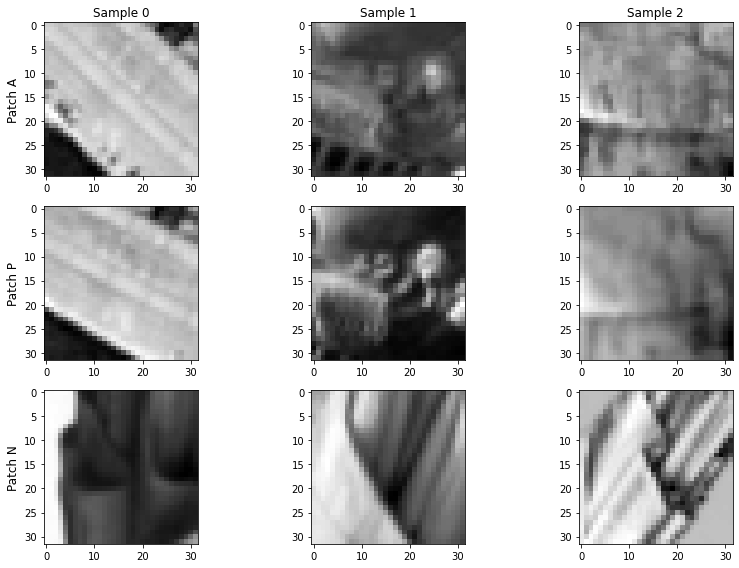

In [6]:
def plot_examples(sample_batched, n_samples=3, labels=['A', 'P', 'N']):
    
    cols = ['Sample {}'.format(col) for col in range(0, n_samples)]
    rows = ['Patch {}'.format(row) for row in labels]
    nrow = len(rows)
    
    fig, axes = plt.subplots(nrows=len(rows), ncols=n_samples, figsize=(12, 8))
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='large')

#     for idx, img_tensor in enumerate(sample_batched):
    for idx in range(nrow):
        img_tensor = sample_batched[idx]
        for jdx in range(n_samples):
            img = img_tensor[jdx, 0]
            axes[idx][jdx].imshow(img, cmap='gray')

    fig.tight_layout()
    plt.show()

for i_batch, sample_batched in enumerate(train_loader):
    print("In training and validation, each data entry generates {} elements: anchor, positive, and negative.".format(len(sample_batched)))
    print("Each of them have the size of: {}".format(sample_batched[0].shape))
    print("Below we show in each column one triplet: top row shows patch a; mid row shows patch p; and bot row shows patch n.")
          
    if i_batch == 0:
        plot_examples(sample_batched, 3)
        break



---
---
<a id='build_network_cell'></a>
## Build an exmaple deep network  

In this section, we will:
#### 1. [Build the deep network: DesNet](#build_desNet_cell)
#### 2. [Setup optimization](#set_opt_cell)

[BackToTop](#top_cell)

---

<a id='build_desNet_cell'></a>
### Build the deep network: DesNet
The DesNet is a simple CNN network, which only contains two CNN blocks.


[BackToSection](#build_network_cell)

In [2]:
# load network from the python file. You need to submit these .py files to TA
from CNN1 import DesNet       # uncomment this line if you are using DesNet from CNN1.py
# from CNN2 import DesNet      # uncomment this line if you are using DesNet from CNN2.py
# from CNN3 import DesNet      # uncomment this line if you are using DesNet from CNN3.py

model = DesNet()
# check model architecture

print(model)

if args.cuda:
    model.cuda()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 128, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)


<a id='set_opt_cell'></a>
### Define optimization
We will use SGD, but you can change it to ADAM by modifying arg.lr in config_profile.py

[BackToSection](#build_network_cell)

In [8]:
# define optimizer
def create_optimizer(model, new_lr):
    # setup optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=new_lr,
                              momentum=0.9, dampening=0.9,
                              weight_decay=args.wd)
    else:
        raise Exception('Not supported optimizer: {0}'.format(args.optimizer))
    return optimizer
optimizer1 = create_optimizer(model.features, args.lr)

---
---
<a id='train_network_cell'></a>
## train the deep network  
In this section, we will:
#### 1. [Define a training module](#define_train_module_cell)
#### 2. [Define a testing module](#define_test_module_cell)
#### 3. [Train and test on the validation data](#training_module_cell)

[BackToTop](#top_cell)

---

<a id='define_train_module_cell'></a>
### Define a training module

[BackToSection](#train_network_cell)

In [9]:
def train(train_loader, model, optimizer, epoch, logger, load_triplets  = False):
    # switch to train mode
    model.train()
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, data in pbar:
        data_a, data_p, data_n = data
        

        if args.cuda:
            data_a, data_p, data_n  = data_a.cuda(), data_p.cuda(), data_n.cuda()
            out_a = model(data_a)
            out_p = model(data_p)
            out_n = model(data_n)
        
        loss = loss_DesNet(out_a, out_p, out_n, anchor_swap = False, margin = 1.0, loss_type = "triplet_margin")
                
        if args.decor:
            loss += CorrelationPenaltyLoss()(out_a)
            
        if args.gor:
            loss += args.alpha*global_orthogonal_regularization(out_a, out_n)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adjust_learning_rate(optimizer)
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                    loss.item()))

    if (args.enable_logging):
        logger.log_value('loss', loss.item()).step()

    try:
        os.stat('{}{}'.format(args.model_dir,suffix))
    except:
        os.makedirs('{}{}'.format(args.model_dir,suffix))

    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
               '{}{}/checkpoint_{}.pth'.format(args.model_dir,suffix,epoch))
    
    
def adjust_learning_rate(optimizer):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0.
        else:
            group['step'] += 1.
        group['lr'] = args.lr * (
        1.0 - float(group['step']) * float(args.batch_size) / (args.n_triplets * float(args.epochs)))
    return

<a id='define_test_module_cell'></a>
### Define a testing module
[BackToSection](#train_network_cell)

In [10]:
def test(test_loader, model, epoch, logger, logger_test_name):
    # switch to evaluate mode
    model.eval()

    losses = 0

    pbar = tqdm(enumerate(test_loader))
    
    for batch_idx, data in pbar:
        data_a, data_p, data_n = data
        

        if args.cuda:
            data_a, data_p, data_n  = data_a.cuda(), data_p.cuda(), data_n.cuda()
            out_a = model(data_a)
            out_p = model(data_p)
            out_n = model(data_n)
        
        loss = loss_DesNet(out_a, out_p, out_n, anchor_swap = False, margin = 1.0, loss_type = "triplet_margin")
        losses = losses + loss.cpu().numpy()
    ave_loss = losses/len(test_loader)
    print('\33[91mLoss on validation: {:.8f}\n\33[0m'.format(ave_loss))

    if (args.enable_logging):
        logger.log_value(logger_test_name+' vloss', ave_loss)
    return


<a id='training_module_cell'></a>
### Training 

[BackToSection](#train_network_cell)

In [11]:
start = args.start_epoch
end = start + args.epochs
logger, file_logger = None, None
triplet_flag = args.load_random_triplets
from Losses import loss_DesNet
TEST_ON_W1BS = True
LOG_DIR = args.log_dir
if(args.enable_logging):
    from Loggers import Logger, FileLogger
    logger = Logger(LOG_DIR)
    
suffix = '{}_{}_{}_as_fliprot'.format(args.experiment_name, args.training_set, args.batch_reduce)

res_fpr_liberty = torch.zeros(end-start,1)
res_fpr_notredame = torch.zeros(end-start, 1)
res_fpr_yosemite = torch.zeros(end-start, 1)

for epoch in range(start, end):

    # iterate over test loaders and test results
    train(train_loader, model, optimizer1, epoch, logger, triplet_flag)
    with torch.no_grad():
        test(validation_loader['dataloader'], model, epoch, logger, validation_loader['name'])

    #randomize train loader batches
    train_loader, _ = create_loaders(dataset_names, load_random_triplets=triplet_flag)

Train Epoch: 0 [92160/100000 (92%)]	Loss: 0.412258: : 98it [00:49,  1.98it/s]
98it [00:48,  2.02it/s]
/scratch/yuanqi3/miniconda3/envs/myenv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:1208: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Loss on validation: 0.36188341

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47595.48it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45223.99it/s]
Train Epoch: 1 [92160/100000 (92%)]	Loss: 0.405278: : 98it [00:50,  1.95it/s]
98it [00:49,  1.98it/s]


Loss on validation: 0.33905029

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 48581.67it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43962.25it/s]
Train Epoch: 2 [92160/100000 (92%)]	Loss: 0.392480: : 98it [00:52,  1.85it/s]
98it [00:51,  1.92it/s]


Loss on validation: 0.32298799

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 48273.18it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43490.95it/s]
Train Epoch: 3 [92160/100000 (92%)]	Loss: 0.339270: : 98it [00:48,  2.00it/s]
98it [00:48,  2.01it/s]


Loss on validation: 0.31170503

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44001.81it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43933.69it/s]
Train Epoch: 4 [92160/100000 (92%)]	Loss: 0.322039: : 98it [00:51,  1.90it/s]
98it [00:50,  1.92it/s]


Loss on validation: 0.29580105

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44985.31it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 46750.98it/s]
Train Epoch: 5 [92160/100000 (92%)]	Loss: 0.310510: : 98it [00:52,  1.86it/s]
98it [00:53,  1.85it/s]


Loss on validation: 0.31120522

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44683.47it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45539.84it/s]
Train Epoch: 6 [92160/100000 (92%)]	Loss: 0.337124: : 98it [00:53,  1.82it/s]
98it [00:50,  1.96it/s]


Loss on validation: 0.28849515

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 48128.18it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44032.34it/s]
Train Epoch: 7 [92160/100000 (92%)]	Loss: 0.292830: : 98it [00:51,  1.89it/s]
98it [00:49,  1.97it/s]


Loss on validation: 0.27684134

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43273.82it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 40471.75it/s]
Train Epoch: 8 [92160/100000 (92%)]	Loss: 0.293056: : 98it [00:53,  1.82it/s]
98it [00:52,  1.87it/s]


Loss on validation: 0.29448117

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44978.75it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 41386.43it/s]
Train Epoch: 9 [92160/100000 (92%)]	Loss: 0.276970: : 98it [00:51,  1.91it/s]
98it [00:51,  1.89it/s]


Loss on validation: 0.27770740

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44341.49it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44107.48it/s]
Train Epoch: 10 [92160/100000 (92%)]	Loss: 0.302312: : 98it [00:51,  1.89it/s]
98it [00:49,  1.96it/s]


Loss on validation: 0.27505852

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 50377.10it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44776.09it/s]
Train Epoch: 11 [92160/100000 (92%)]	Loss: 0.267962: : 98it [00:50,  1.94it/s]
98it [00:50,  1.96it/s]


Loss on validation: 0.27969540

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 46844.89it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42603.99it/s]
Train Epoch: 12 [92160/100000 (92%)]	Loss: 0.269710: : 98it [00:50,  1.94it/s]
98it [00:50,  1.93it/s]


Loss on validation: 0.26997266

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44295.81it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45346.54it/s]
Train Epoch: 13 [92160/100000 (92%)]	Loss: 0.283242: : 98it [00:50,  1.95it/s]
98it [00:50,  1.96it/s]


Loss on validation: 0.27265944

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 49331.72it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42055.15it/s]
Train Epoch: 14 [92160/100000 (92%)]	Loss: 0.258396: : 98it [00:51,  1.92it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.25861433

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43801.56it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43336.10it/s]
Train Epoch: 15 [92160/100000 (92%)]	Loss: 0.264715: : 98it [00:52,  1.88it/s]
98it [00:50,  1.94it/s]


Loss on validation: 0.26354304

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 46352.20it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 46836.41it/s]
Train Epoch: 16 [92160/100000 (92%)]	Loss: 0.291332: : 98it [00:52,  1.87it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.26312042

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47051.04it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45263.80it/s]
Train Epoch: 17 [92160/100000 (92%)]	Loss: 0.279299: : 98it [00:51,  1.89it/s]
98it [00:51,  1.90it/s]


Loss on validation: 0.25095470

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 46911.94it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42847.81it/s]
Train Epoch: 18 [92160/100000 (92%)]	Loss: 0.257963: : 98it [00:50,  1.92it/s]
98it [00:52,  1.86it/s]


Loss on validation: 0.26527585

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44760.70it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44693.58it/s]
Train Epoch: 19 [92160/100000 (92%)]	Loss: 0.270325: : 98it [00:49,  1.98it/s]
98it [00:51,  1.90it/s]


Loss on validation: 0.25893648

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 51853.87it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 51372.30it/s]
Train Epoch: 20 [92160/100000 (92%)]	Loss: 0.262962: : 98it [00:50,  1.93it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.25445088

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 52775.28it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 41856.22it/s]
Train Epoch: 21 [92160/100000 (92%)]	Loss: 0.256661: : 98it [00:52,  1.85it/s]
98it [00:49,  1.99it/s]


Loss on validation: 0.24154685

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 46510.61it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 40612.57it/s]
Train Epoch: 22 [92160/100000 (92%)]	Loss: 0.279246: : 98it [00:51,  1.89it/s]
98it [00:48,  2.03it/s]


Loss on validation: 0.24791215

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45860.23it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44010.64it/s]
Train Epoch: 23 [92160/100000 (92%)]	Loss: 0.259326: : 98it [00:50,  1.95it/s]
98it [00:49,  1.97it/s]


Loss on validation: 0.24842386

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45262.87it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 46276.47it/s]
Train Epoch: 24 [92160/100000 (92%)]	Loss: 0.245187: : 98it [00:52,  1.85it/s]
98it [00:50,  1.96it/s]


Loss on validation: 0.25510213

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 48362.27it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43690.18it/s]
Train Epoch: 25 [92160/100000 (92%)]	Loss: 0.265620: : 98it [00:52,  1.88it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.24261243

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44734.04it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42921.78it/s]
Train Epoch: 26 [92160/100000 (92%)]	Loss: 0.258144: : 98it [00:53,  1.84it/s]
98it [00:50,  1.94it/s]


Loss on validation: 0.24712906

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45903.47it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 40176.28it/s]
Train Epoch: 27 [92160/100000 (92%)]	Loss: 0.256911: : 98it [00:51,  1.91it/s]
98it [00:49,  1.98it/s]


Loss on validation: 0.23795763

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45383.27it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45099.76it/s]
Train Epoch: 28 [92160/100000 (92%)]	Loss: 0.235659: : 98it [00:50,  1.95it/s]
98it [00:51,  1.90it/s]


Loss on validation: 0.24392482

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45608.86it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44882.73it/s]
Train Epoch: 29 [92160/100000 (92%)]	Loss: 0.246843: : 98it [00:52,  1.86it/s]
98it [00:51,  1.91it/s]


Loss on validation: 0.23679279

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47281.38it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42270.95it/s]
Train Epoch: 30 [92160/100000 (92%)]	Loss: 0.243820: : 98it [00:52,  1.87it/s]
98it [00:49,  1.96it/s]


Loss on validation: 0.23772941

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45207.96it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44791.32it/s]
Train Epoch: 31 [92160/100000 (92%)]	Loss: 0.249058: : 98it [00:49,  1.97it/s]
98it [00:50,  1.93it/s]


Loss on validation: 0.24237600

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44379.99it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44279.93it/s]
Train Epoch: 32 [92160/100000 (92%)]	Loss: 0.240864: : 98it [00:50,  1.94it/s]
98it [00:49,  1.97it/s]


Loss on validation: 0.24330664

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44886.75it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45702.70it/s]
Train Epoch: 33 [92160/100000 (92%)]	Loss: 0.248646: : 98it [00:51,  1.91it/s]
98it [00:50,  1.94it/s]


Loss on validation: 0.24126515

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43706.95it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45077.33it/s]
Train Epoch: 34 [92160/100000 (92%)]	Loss: 0.250058: : 98it [00:53,  1.84it/s]
98it [00:49,  1.97it/s]


Loss on validation: 0.23650140

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 46812.34it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43444.90it/s]
Train Epoch: 35 [92160/100000 (92%)]	Loss: 0.236384: : 98it [00:52,  1.86it/s]
98it [00:49,  1.99it/s]


Loss on validation: 0.23441939

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44664.41it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 40449.69it/s]
Train Epoch: 36 [92160/100000 (92%)]	Loss: 0.248607: : 98it [00:53,  1.84it/s]
98it [00:49,  1.99it/s]


Loss on validation: 0.23915278

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47364.76it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 47832.51it/s]
Train Epoch: 37 [92160/100000 (92%)]	Loss: 0.240170: : 98it [00:50,  1.92it/s]
98it [00:49,  1.99it/s]


Loss on validation: 0.23337845

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47546.63it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 43449.48it/s]
Train Epoch: 38 [92160/100000 (92%)]	Loss: 0.231026: : 98it [00:50,  1.92it/s]
98it [00:52,  1.88it/s]


Loss on validation: 0.23241438

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43986.09it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44549.79it/s]
Train Epoch: 39 [92160/100000 (92%)]	Loss: 0.263242: : 98it [00:50,  1.94it/s]
98it [00:47,  2.06it/s]


Loss on validation: 0.23356168

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47309.67it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 48745.24it/s]
Train Epoch: 40 [92160/100000 (92%)]	Loss: 0.275868: : 98it [00:51,  1.88it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.23457756

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 48835.12it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45115.65it/s]
Train Epoch: 41 [92160/100000 (92%)]	Loss: 0.238567: : 98it [00:52,  1.88it/s]
98it [00:49,  1.97it/s]


Loss on validation: 0.23403599

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47602.22it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42348.56it/s]
Train Epoch: 42 [92160/100000 (92%)]	Loss: 0.235099: : 98it [00:53,  1.85it/s]
98it [00:48,  2.03it/s]


Loss on validation: 0.23592652

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 49483.35it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 38532.44it/s]
Train Epoch: 43 [92160/100000 (92%)]	Loss: 0.226914: : 98it [00:50,  1.96it/s]
98it [00:48,  2.04it/s]


Loss on validation: 0.23114640

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 42979.15it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42539.38it/s]
Train Epoch: 44 [92160/100000 (92%)]	Loss: 0.235405: : 98it [00:50,  1.94it/s]
98it [00:49,  1.99it/s]


Loss on validation: 0.23229894

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43955.94it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 40074.70it/s]
Train Epoch: 45 [92160/100000 (92%)]	Loss: 0.241689: : 98it [00:51,  1.90it/s]
98it [00:49,  1.98it/s]


Loss on validation: 0.23441921

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45601.19it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44380.32it/s]
Train Epoch: 46 [92160/100000 (92%)]	Loss: 0.249160: : 98it [00:53,  1.83it/s]
98it [00:49,  2.00it/s]


Loss on validation: 0.22624255

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47470.63it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 48007.78it/s]
Train Epoch: 47 [92160/100000 (92%)]	Loss: 0.240833: : 98it [00:51,  1.89it/s]
98it [00:52,  1.88it/s]


Loss on validation: 0.22339490

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 43836.89it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42581.56it/s]
Train Epoch: 48 [92160/100000 (92%)]	Loss: 0.253912: : 98it [00:49,  1.96it/s]
98it [00:43,  2.25it/s]


Loss on validation: 0.22524150

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 55693.62it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 56246.01it/s]
Train Epoch: 49 [92160/100000 (92%)]	Loss: 0.241235: : 98it [00:46,  2.09it/s]
98it [00:43,  2.23it/s]


Loss on validation: 0.23076989

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 57285.92it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 52109.74it/s]
Train Epoch: 50 [92160/100000 (92%)]	Loss: 0.221962: : 98it [00:46,  2.10it/s]
98it [00:43,  2.24it/s]


Loss on validation: 0.22864694

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 56736.73it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 50370.50it/s]
Train Epoch: 51 [92160/100000 (92%)]	Loss: 0.222760: : 98it [00:44,  2.19it/s]
98it [00:43,  2.28it/s]


Loss on validation: 0.23490784

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 56334.08it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 54117.21it/s]
Train Epoch: 52 [92160/100000 (92%)]	Loss: 0.232655: : 98it [00:44,  2.19it/s]
98it [00:43,  2.24it/s]


Loss on validation: 0.22541955

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 52635.69it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 53474.71it/s]
Train Epoch: 53 [92160/100000 (92%)]	Loss: 0.262849: : 98it [00:46,  2.11it/s]
98it [00:42,  2.28it/s]


Loss on validation: 0.22723213

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 47469.97it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 46551.37it/s]
Train Epoch: 54 [92160/100000 (92%)]	Loss: 0.228325: : 98it [00:46,  2.11it/s]
98it [00:44,  2.18it/s]


Loss on validation: 0.22843768

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 54379.02it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 51633.95it/s]
Train Epoch: 55 [92160/100000 (92%)]	Loss: 0.241337: : 98it [00:44,  2.22it/s]
98it [00:47,  2.07it/s]


Loss on validation: 0.22922518

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 45734.09it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 46653.22it/s]
Train Epoch: 56 [92160/100000 (92%)]	Loss: 0.238676: : 98it [00:52,  1.87it/s]
98it [00:50,  1.95it/s]


Loss on validation: 0.23191314

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 50377.25it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 42903.28it/s]
Train Epoch: 57 [92160/100000 (92%)]	Loss: 0.217252: : 98it [00:49,  1.96it/s]
98it [00:47,  2.05it/s]


Loss on validation: 0.22919534

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:02<00:00, 44923.14it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 44832.93it/s]
Train Epoch: 58 [92160/100000 (92%)]	Loss: 0.219394: : 98it [00:49,  1.96it/s]
98it [00:48,  2.03it/s]


Loss on validation: 0.22928490

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 50135.28it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 45170.01it/s]
Train Epoch: 59 [92160/100000 (92%)]	Loss: 0.227818: : 98it [00:48,  2.01it/s]
98it [00:45,  2.14it/s]


Loss on validation: 0.22951534

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 53126.72it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:02<00:00, 49321.36it/s]


### Select the best model, and save it as CNN*.pth; * can be 1, 2, or 3.

---
---
<a id='generate_deep_features_cell'></a>
## Generate deep features
In this section, we will use your trained network to generate deep features for each patch:
#### 1. [load weights](#load_weights_module_cell)
#### 2. [load patches](#load_raw_patch_files_module_cell)
#### 3. [get deep features](#get_deep_features_module_cell)



[BackToTop](#top_cell)

<a id='load_weights_module_cell'></a>
### Load network weights
[BackToSection](#generate_deep_features_cell)

In [3]:
trained_weight_path = "models1_4/liberty_train/_liberty_min_as_fliprot/checkpoint_47.pth" # suppose you select  checkpoint_4.pth as the best model for this architecture
test_model = DesNet()
if args.cuda:
    test_model.cuda()
trained_weight = torch.load(trained_weight_path)['state_dict']
test_model.load_state_dict(trained_weight)
test_model.eval()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 128, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
)

<a id='load_raw_patch_files_module_cell'></a>
### Load raw patch files
Assume that the raw patch file is stored as patches.pth

[BackToSection](#generate_deep_features_cell)

In [4]:
patches_dir = "SIFT_patches.pth"            # these patches are from keypoint detection results
patches = torch.load(patches_dir)
print(patches.shape)                  # in your case, the shape should be [10, 200, 1, 32, 32]
num_imgs, num_pts, _, _, _ = patches.shape
patches = patches.view(-1, 1, 32, 32).cuda()
print(patches.shape)


torch.Size([10, 200, 1, 32, 32])
torch.Size([2000, 1, 32, 32])


<a id='get_deep_features_module_cell'></a>
### Get deep features
[BackToSection](#generate_deep_features_cell)

In [5]:
features = test_model(patches)
print(features.shape)
# patches = torch.load(patches_dir)
features = features.view(num_imgs, num_pts, 128).cpu().data
print(features.shape)                  # in your case, the shape should be [10, 200, 128]

torch.Size([2000, 128])
torch.Size([10, 200, 128])


In [6]:
# save to file, with the name of *_features_CNN*.pth
features_dir = "features_CNN1_SIFT.pth"
torch.save(features, features_dir)

In [8]:
patches_dir = "Harris_patches.pth"            # these patches are from keypoint detection results
patches = torch.load(patches_dir)
print(patches.shape)                  # in your case, the shape should be [10, 200, 1, 32, 32]
num_imgs, num_pts, _, _, _ = patches.shape
patches = patches.view(-1, 1, 32, 32).cuda()
print(patches.shape)

features = test_model(patches)
print(features.shape)
# patches = torch.load(patches_dir)
features = features.view(num_imgs, num_pts, 128).cpu().data
print(features.shape)    

# save to file, with the name of *_features_CNN*.pth
features_dir = "features_CNN1_Harris.pth"
torch.save(features, features_dir)

torch.Size([10, 200, 1, 32, 32])
torch.Size([2000, 1, 32, 32])
torch.Size([2000, 128])
torch.Size([10, 200, 128])
